# Problem Statement


model Classification untuk memprediksi default_payment_next_month dalam Prediksi pembayaran tertunda kartu kredit.

# Objective

* Prediksi pembayaran tertunda: Berdasarkan riwayat pembayaran kartu kredit sebelumnya, dapat diprediksi apakah seseorang akan membayar tagihan kartu kredit mereka pada waktu yang tepat atau akan terlambat. Jika seseorang cenderung terlambat membayar tagihan, bank penerbit kartu kredit dapat mengambil tindakan preventif, seperti mengirimkan pemberitahuan, menyesuaikan batas kredit atau jika memang tidak membayar berkelanjutan akan disuspend.



# ii. Import Library

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from phik import phik_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from feature_engine.outliers import Winsorizer

#model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier


#evaluasi
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer, recall_score, precision_score

#save model
import pickle


import warnings
warnings.filterwarnings(action='ignore')

--BigQuery SQL

* SELECT limit_balance, 
CAST(sex AS INT64) AS sex, 
CAST(education_level AS INT64) AS education_level, CAST(marital_status AS INT64) AS material_status, columns, pay_0, pay_2, pay_3, pay_4, CAST(pay_5 AS FLOAT64) AS pay_5, CAST(pay_6 AS FLOAT64) AS pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, CAST(default_payment_next_month AS INT64) AS default_payment_next_month
* FROM `bigquery-public-data.ml_datasets.credit_card_default` 
* LIMIT 7988 

--- keterangan kolom

* LIMIT_BAL: Jumlah kredit yang diberikan, termasuk kredit individu dan tambahan.
* SEX: Jenis kelamin pelanggan (1 = pria, 2 = wanita)
* EDUCATION: (1 = graduate school; 2 = university; 3 = high school; 4 = others)
* MARRIAGE: (1 = married; 2 = single; 3 = others)
* AGE: Usia pelanggan
* PAY_0: Riwayat status pelunasan sebelumnya, apakah dibayar tepat waktu atau keterlambatan pembayaran. PAY_0 = status pembayaran di bulan September. Skala (berlaku untuk PAY_0 hingga Pay_6): -1 = bayar dengan semestinya, 1 = penundaan pembayaran selama * 1 bulan, 2 = penundaan pembayaran selama 2 bulan, ... 9 = penundaan pembayaran selama 9 bulan atau lebih)
* -2 : Saldo telah dibayar dan belum ada transaksi untuk bulan tersebut, yaitu. tidak ada kredit yang harus dibayar
* -1 : Saldo telah dibayar penuh tetapi ada beberapa transaksi selama bulan tersebut yang tidak tercermin pada laporan tagihan saat ini
* 0 : Pelanggan telah membayar minimal jumlah minimum yang dipersyaratkan, namun masih ada sisa saldo yang harus dibayar
* 1-9 Ketika seorang pelanggan tidak membayar jumlah minimum yang disyaratkan, itu dianggap sebagai pembayaran yang terlewatkan untuk bulan itu. Angka 1-9 akan sesuai dengan bulan kumulatif dari pembayaran yang terlewatkan pada saat itu.
* PAY_2: repayment status in August
* PAY_3: repayment status in July
* PAY_4: repayment status in June
* PAY_5: repayment status in May
* PAY_6: repayment status in April
* BILL_AMT1: Jumlah tagihan September
* BILL_AMT2: Jumlah tagihan August
* BILL_AMT3: Jumlah tagihan July
* BILL_AMT4: Jumlah tagihan June
* BILL_AMT5: Jumlah tagihan May
* BILL_AMT6: Jumlah tagihan April
* PAY_AMT1: Jumlah yang dibayarkan September
* PAY_AMT2: Jumlah yang dibayarkan August
* PAY_AMT3: Jumlah yang dibayarkan July
* PAY_AMT4: Jumlah yang dibayarkan June
* PAY_AMT5: Jumlah yang dibayarkan May
* PAY_AMT6: Jumlah yang dibayarkan April
* default_payment_next_month: apakah klien gagal membayar (0 = No, 1 = Yes)

# iii. Data Loading

In [41]:
#loading data dan handle missingvalue non-standard
missing_values = ["n/a", "na", "--",' ?','-', '?','? ','none']
df = pd.read_csv('h8dsft_P1M1_Hanifah.csv',na_values = missing_values)
df.head(10)

,limit_balance,sex,education_level,material_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,-1.0,54053.0,65235.0,64747.0,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,0.0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


Berikut adalah data default_payment_next_month berasal dari US, menghandle minsing value yang non standard seperti ["n/a", "na", "--",'?'] di ganti menjadi nan value dan menampilkan 10 data teratas.

In [42]:
#display max
pd.set_option('display.max_columns',None)


In [43]:
#memunculkan 10 terbawah
df.tail(10)

,limit_balance,sex,education_level,material_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,12878.0,7702.0,2377.0,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-100.0,100.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,5280.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,96.0,780.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-70.0,9540.0,390.0,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   material_status             2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [45]:
df.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
material_status               0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

Pada dataset beriku tidak terdapat missing value

# iv. Exploratory Data Analysis (EDA)

In [46]:
#cek uniq nilai untuk nonstandard missing value
for i in df:
    print(i, ':' , df[i].unique(), '\n')

limit_balance : [ 80000. 200000.  20000. 260000. 150000. 300000. 130000. 500000. 230000.
 460000. 780000. 170000. 320000. 290000. 240000. 340000. 360000. 380000.
 180000. 100000.  90000.  50000. 160000.  70000. 280000. 220000.  30000.
 120000.  10000. 470000. 310000. 140000.  60000. 110000. 430000. 210000.
 490000. 330000. 250000. 400000. 370000. 440000. 700000. 530000. 390000.
 410000. 270000. 560000.  40000. 680000. 480000. 190000. 350000. 420000.
 510000. 800000. 450000. 750000. 620000.] 

sex : [1 2] 

education_level : [6 4 1 2 3 5 0] 

material_status : [1 2 3 0] 

age : [54. 49. 22. 33. 32. 45. 58. 39. 48. 34. 47. 46. 30. 35. 55. 42. 56. 31.
 53. 40. 36. 51. 37. 44. 24. 38. 26. 25. 23. 27. 28. 29. 41. 63. 50. 43.
 66. 61. 52. 62. 69. 21. 65. 57. 64. 67. 60. 59. 68.] 

pay_0 : [ 0.  2.  1. -1. -2.  3.  4.  5.  6.  7.  8.] 

pay_2 : [ 0. -1.  2.  3. -2.  4.  1.  5.  6.  7.] 

pay_3 : [ 0.  2. -2.  3. -1.  4.  5.  6.  7.] 

pay_4 : [ 0. -1.  2.  3.  4.  5.  6.  7.  8. -2.] 

pay_5 

In [47]:
#Cek duplikat
df.duplicated().sum()

1

Terdapat 1 kolom duplicat

In [48]:
#drop duplicat
df.drop_duplicates(inplace=True)

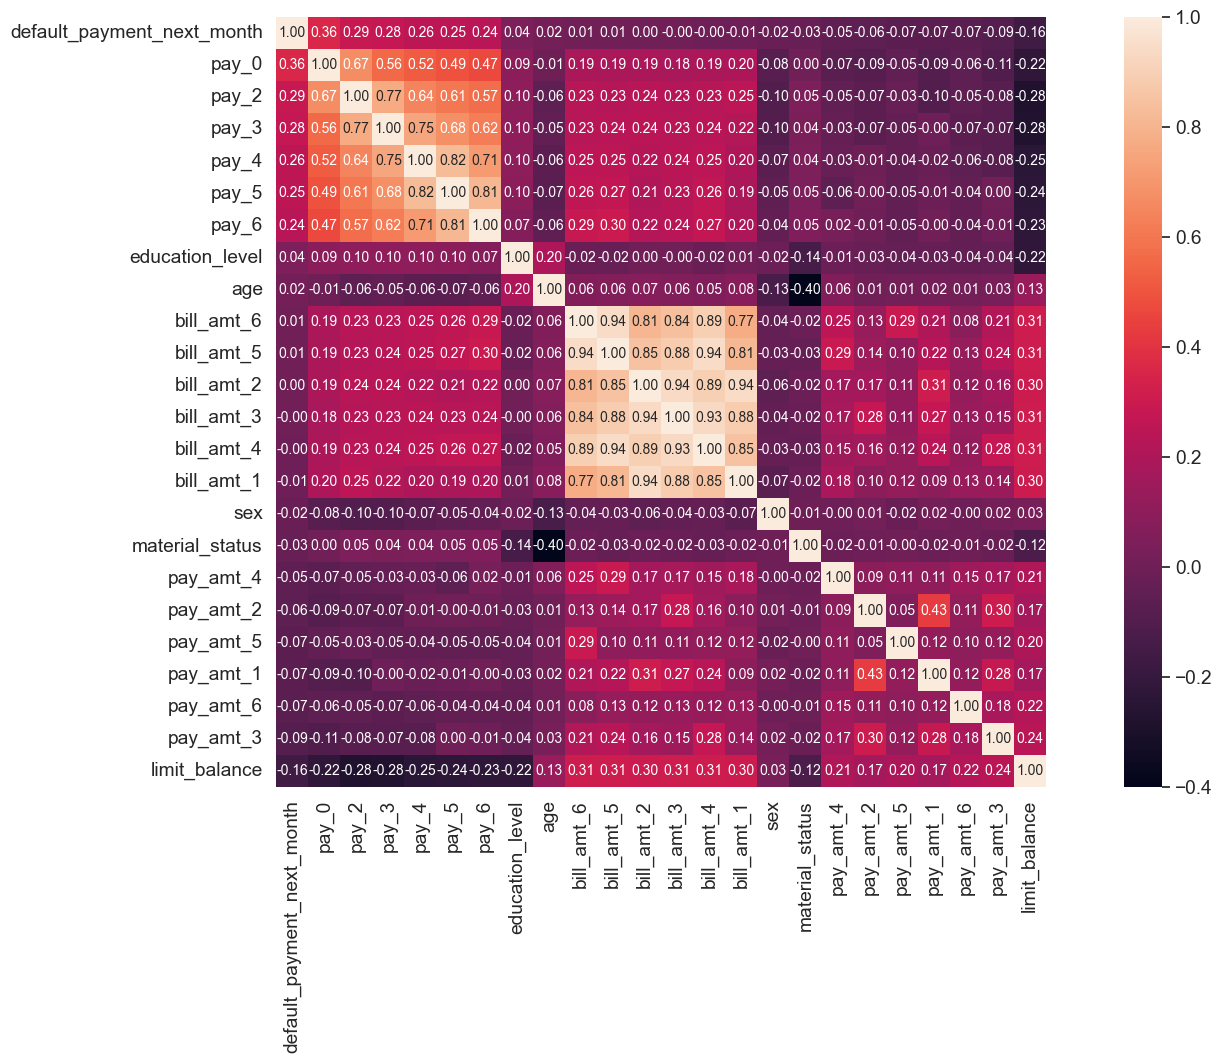

In [49]:
#cek korelasi numerikal 
k = 30 # number of variables dari heatmap
plt.figure(figsize=(20,10))
cols = df.corr().nlargest(k, 'default_payment_next_month')['default_payment_next_month'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

membuat heatmap pada dataframe numerical untuk melihat korelasi antara kolom target dengan kolom feature dimana kolom yang memiliki nilai korelasi yang tinggi dengan kolom target dibandingkan dengan nilai koresalasi kolom lainnya.

In [50]:
#phik korelation untuk numerikal dan kategorikal
df.phik_matrix().nlargest(30,'default_payment_next_month')['default_payment_next_month']

interval columns not set, guessing: ['limit_balance', 'sex', 'education_level', 'material_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'default_payment_next_month']


default_payment_next_month    1.000000
pay_0                         0.596572
pay_2                         0.468335
pay_6                         0.386559
pay_3                         0.334726
pay_4                         0.318688
pay_5                         0.315415
limit_balance                 0.191907
bill_amt_4                    0.087360
education_level               0.085359
pay_amt_3                     0.083774
bill_amt_1                    0.073974
bill_amt_3                    0.073073
age                           0.067038
bill_amt_2                    0.064086
pay_amt_4                     0.062588
pay_amt_1                     0.046866
pay_amt_5                     0.022282
material_status               0.020055
bill_amt_5                    0.019495
sex                           0.015281
pay_amt_2                     0.004992
bill_amt_6                    0.000000
pay_amt_6                     0.000000
Name: default_payment_next_month, dtype: float64

Phik matrik di gunakan untuk menghitung korelasi numerikal dan kategorikal untuk melihat korelasi antara kolom target dengan kolom feature dimana kolom yang memiliki nilai korelasi yang tinggi dengan kolom target dibandingkan dengan nilai koresalasi kolom lainnya. Dari data diatas didapatkan nilai korelasi antara target dengan feature, berikut bisa di jakan sebagai pemilihan pada feature yang akan di prediksi, berdasarkan dari jumlah korelasi semua kolom terdapat korelasi dengan target.

In [51]:
# Calculating VIF (Multicollinearity)
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(by=['VIF'],ascending=False)
    return(vif)

In [52]:
X = df.iloc[:,:-6]
calc_vif(X)

,variables,VIF
12,bill_amt_2,37.090243
15,bill_amt_5,24.378701
11,bill_amt_1,23.493489
14,bill_amt_4,22.362743
13,bill_amt_3,18.929368
16,bill_amt_6,13.275188
4,age,11.125620
1,sex,9.090537
2,education_level,6.947318
3,material_status,6.505135


Multicollinearity adalah suatu kondisi di mana dua atau lebih variabel independen dalam model regresi memiliki korelasi yang tinggi satu sama lain. Hal ini dapat menyebabkan masalah dalam interpretasi koefisien regresi dan ketidakpastian estimasi model, karena efek dari setiap variabel independen sulit dipisahkan. batasan dari multicolarity yang di gunakan adalah 10, maka dari data di atas dapat kita lihat kolom dengan nilai lebih besar dari 10 akan di drop karena multicolarity, namun ada beberapa hal dalam pemilian feature selection berdasarkan jugment pribadi dengan asumsinya informasi dengan nilai VIF besar mendukung dalam hal prediksi yang di perlukan misalnya age, bill_amt4,bill_amt3 

In [103]:
limit_balance_unique = df.limit_balance.unique()

In [104]:
# Menentukan persentase minimum pembayaran
minimum_payment_percent = 0.03

# Melakukan looping pada setiap baris data

for i in range(len(limit_balance_unique)) :
    
    minimum_payment = limit_balance_unique[i] * minimum_payment_percent
    print(f"Minimum payment untuk {limit_balance_unique[i]}: {minimum_payment}")

    pd.set_option('display.max_columns',None)


Minimum payment untuk 80000.0: 2400.0
Minimum payment untuk 200000.0: 6000.0
Minimum payment untuk 20000.0: 600.0
Minimum payment untuk 260000.0: 7800.0
Minimum payment untuk 150000.0: 4500.0
Minimum payment untuk 300000.0: 9000.0
Minimum payment untuk 130000.0: 3900.0
Minimum payment untuk 500000.0: 15000.0
Minimum payment untuk 230000.0: 6900.0
Minimum payment untuk 460000.0: 13800.0
Minimum payment untuk 780000.0: 23400.0
Minimum payment untuk 170000.0: 5100.0
Minimum payment untuk 320000.0: 9600.0
Minimum payment untuk 290000.0: 8700.0
Minimum payment untuk 240000.0: 7200.0
Minimum payment untuk 340000.0: 10200.0
Minimum payment untuk 360000.0: 10800.0
Minimum payment untuk 380000.0: 11400.0
Minimum payment untuk 180000.0: 5400.0
Minimum payment untuk 100000.0: 3000.0
Minimum payment untuk 90000.0: 2700.0
Minimum payment untuk 50000.0: 1500.0
Minimum payment untuk 160000.0: 4800.0
Minimum payment untuk 70000.0: 2100.0
Minimum payment untuk 280000.0: 8400.0
Minimum payment untuk 220

Dari data ini di asumsikan bahwa persentasi dari pinjaman adalah 3% yang harus di bayar oleh customer, berikut adalah nilai minimum yang harus di bayar di setiap bulanya. data ini akan memberikan informasi untuk kolom pay amount.

In [55]:
# untuk melihat jumlah dari masing masing umur yang menggunakan kartu kredit
df.groupby(['age'])[['default_payment_next_month']].count().sort_values(by='age', ascending=True)

,default_payment_next_month
age,
21.0,7
22.0,49
23.0,95
24.0,120
25.0,119
26.0,138
27.0,146
28.0,138
29.0,149


keterangan diatas memberika informasi bahwa dari dataset ini terdapat dari usia 21 - 71 tahun dengan jumlah paling banyak yang memiliki kredit adalah umur 30 th.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2964 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2964 non-null   float64
 1   sex                         2964 non-null   int64  
 2   education_level             2964 non-null   int64  
 3   material_status             2964 non-null   int64  
 4   age                         2964 non-null   float64
 5   pay_0                       2964 non-null   float64
 6   pay_2                       2964 non-null   float64
 7   pay_3                       2964 non-null   float64
 8   pay_4                       2964 non-null   float64
 9   pay_5                       2964 non-null   float64
 10  pay_6                       2964 non-null   float64
 11  bill_amt_1                  2964 non-null   float64
 12  bill_amt_2                  2964 non-null   float64
 13  bill_amt_3                  2964 

In [57]:
# add a new column for sex_newgroup
df['sex_new'] = ''

# loop through the DataFrame and add a category based on age
for i, row in df.iterrows():
    sex = row['sex']
    if np.isnan(sex):
        df.at[i, 'sex_new'] = 'Unknown'
    elif sex < 1 and sex > 2:
        df.at[i, 'sex_new'] = 'Out of range'
    elif sex == 1:
        df.at[i, 'sex_new'] = 'male'
    elif sex == 2:
        df.at[i, 'sex_new'] = 'female'

menggkategorikan dari informasi kolom ke bentuk kategori:
1 = male
2 = female


In [58]:
# add a new column for material_status_new' group
df['material_status_new'] = ''

# loop through the DataFrame and add a category based on age
for i, row in df.iterrows():
    material_status = row['material_status']
    if np.isnan(material_status):
        df.at[i, 'material_status_new'] = 'Unknown'
    elif material_status < 0 and material_status> 3:
        df.at[i, 'material_status_new'] = 'Out of range'
    elif material_status == 0:
        df.at[i, 'material_status_new'] = 'other'
    elif material_status == 1:
        df.at[i, 'material_status_new'] = 'married'
    elif material_status == 2:
        df.at[i, 'material_status_new'] = 'single'
    elif material_status == 3:
        df.at[i, 'material_status_new'] = 'other'

mengkategorikan dari informasi kolom numerik ke bentuk kategori:
1 = married
2 = singgle
0 & 3 = other

In [59]:
# add a new column for 'education_level_new' group
df['education_level_new'] = ''

# loop through the DataFrame and add a category based on age
for i, row in df.iterrows():
    education_level = row['education_level']
    if np.isnan(education_level):
        df.at[i, 'education_level_new'] = 'Unknown'
    elif education_level < 0 and education_level > 6:
        df.at[i, 'education_level_new'] = 'Out of range'
    elif education_level == 0:
        df.at[i, 'education_level_new'] = 'other'
    elif education_level == 1:
        df.at[i, 'education_level_new'] = 'post-graduate'
    elif education_level == 2:
        df.at[i, 'education_level_new'] = 'bachelors'
    elif education_level == 3:
        df.at[i, 'education_level_new'] = 'high school'
    elif education_level >= 4 and education_level <= 6:
        df.at[i, 'education_level_new'] = 'other'

mengkategorikan dari informasi kolom numerik ke bentuk kategori:
1 = post-graduate
2 = bachelors
3 = high school
4-6 = other

In [60]:
# add a new column for 'default_payment_next_month_new' group
df['default_payment_next_month_new'] = ''

# loop through the DataFrame and add a category based on age
for i, row in df.iterrows():
    default_payment_next_month = row['default_payment_next_month']
    if np.isnan(default_payment_next_month):
        df.at[i, 'default_payment_next_month_new'] = 'Unknown'
    elif default_payment_next_month < 0 and default_payment_next_month > 1:
        df.at[i, 'default_payment_next_month_new'] = 'Out of range'
    elif default_payment_next_month == 0:
        df.at[i, 'default_payment_next_month_new'] = 'no'
    elif default_payment_next_month == 1:
        df.at[i, 'default_payment_next_month_new'] = 'yes'


Dari kolom target berikut menentukan continue atau drop dari kartu kredit 

* 1 = gagal bayar (tidak membayar total payment yang seharusnya di bayarkan)
* 0 = continue (mentaati rules/membayar payment yang seharusnya dibayarkan)

In [61]:
# add a new column for age group
df['age_group'] = ''

# loop through the DataFrame and add a category based on age
for i, row in df.iterrows():
    age = row['age']
    if np.isnan(age):
        df.at[i, 'age_group'] = 'Unknown'
    elif age < 21.0 or age > 69.0:
        df.at[i, 'age_group'] = 'Out of range'
    elif age >= 21.0 and age <= 29.0:
        df.at[i, 'age_group'] = '21-29'
    elif age >= 30.0 and age <= 39.0:
        df.at[i, 'age_group'] = '30-39'
    elif age >= 40.0 and age <= 49.0:
        df.at[i, 'age_group'] = '40-49'
    elif age >= 50.0 and age <= 59.0:
        df.at[i, 'age_group'] = '50-59'
    else:
        df.at[i, 'age_group'] = '60-69'

In [62]:
df.head(5)

,limit_balance,sex,education_level,material_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,sex_new,material_status_new,education_level_new,default_payment_next_month_new,age_group
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1,male,married,other,yes,50-59
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0,male,married,other,no,40-49
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1,female,single,other,yes,21-29
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0,female,single,other,no,30-39
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0,male,single,other,no,30-39


In [63]:
#groupby'gender' berdasarkan limit balance yang di rata rata,min,max,count
df.groupby(['sex_new'])[['limit_balance']].aggregate(['mean','min','max','count'])

limit_balance                         
                  mean      min       max count
sex_new                                        
female   166218.767351  10000.0  750000.0  1801
male     158925.193465  10000.0  800000.0  1163

Dari informasi di atas dapat di lihat bahwa jumlah yang memiliki kredit yang tinggi berdasarkan gender cenderung perempuan di bandingkan laki-laki begitupun rata rata limit baance perempuan lebih besar dibandingkan dengan laki-laki

In [64]:
#groupby'gender' berdasarkan limit balance yang di rata rata,min,max,count
df.groupby(['education_level_new'])[['limit_balance']].aggregate(['mean','min','max','count'])

limit_balance                         
                              mean      min       max count
education_level_new                                        
bachelors            144964.285714  10000.0  800000.0  1400
high school          124409.937888  10000.0  510000.0   483
other                169534.883721  20000.0  420000.0    43
post-graduate        206030.828516  10000.0  780000.0  1038

Dari informasi di atas dapat di lihat bahwa jumlah yang memiliki kredit yang tinggi berdasarkan education level, background education bachelor adalah yang paling tinggi menggunakan kredit disusul dngan post-graduated,high scholl dan other

In [65]:
#groupby'gender' berdasarkan limit balance yang di rata rata,min,max,count
df.groupby(['age_group'])[['limit_balance']].aggregate(['mean','min','max','count'])

limit_balance                         
                    mean      min       max count
age_group                                        
21-29      120468.262227  10000.0  500000.0   961
30-39      195740.740741  10000.0  700000.0  1134
40-49      172195.121951  10000.0  780000.0   615
50-59      157201.834862  10000.0  800000.0   218
60-69      174444.444444  10000.0  510000.0    36

berdasarkan kategory umur, berkisar di umur 30-39 tahun yang banyak menggunakan kartu kredit

In [66]:
#membuat fungsi untuk plot 
def plotting_Profit(x:str,hue:str):    #ukuran plot diatur dengan menggunakan parameter figsize dengan method subplots
    try:
        fig, ax = plt.subplots(figsize=(10,5))
        colors = [
            
            'purple','green',   # warna pada plot
            'teal','purple',
            'tan','aqua',
            
                
        ]
        
        ordering =df[x].value_counts()  # menggunakan method value_counts pada kolom x dari DataFrame df dan menghitung frekuensi setiap nilai unik di kolom x
        my_palette = sns.xkcd_palette(colors)
        sns.set_theme(style='whitegrid')
        sns.countplot(data=df, x=x, hue=hue,palette=my_palette, #mengatur urutan nilai di sumbu x berdasarkan urutan kategori pada list order
        order=ordering.sort_values().index[::-1], # mengurutkan nilai di sumbu x secara menurun berdasarkan jumlahnya.
        )
        ax.tick_params(axis='x', rotation=45) #sumbu x diputar 45 derajat agar lebih mudah dibaca.
        ax.set_title(f'Menghitung Plot Number dari {x} Dengan {hue}',fontsize=20)

        ax.set_xlabel(f"{x}", fontdict={'fontsize':20})
        ax.set_ylabel("Count", fontdict={'fontsize':20})
    except ValueError:
            print(f"The wrong Value was passed\nPlease look are the information below\n")
            df

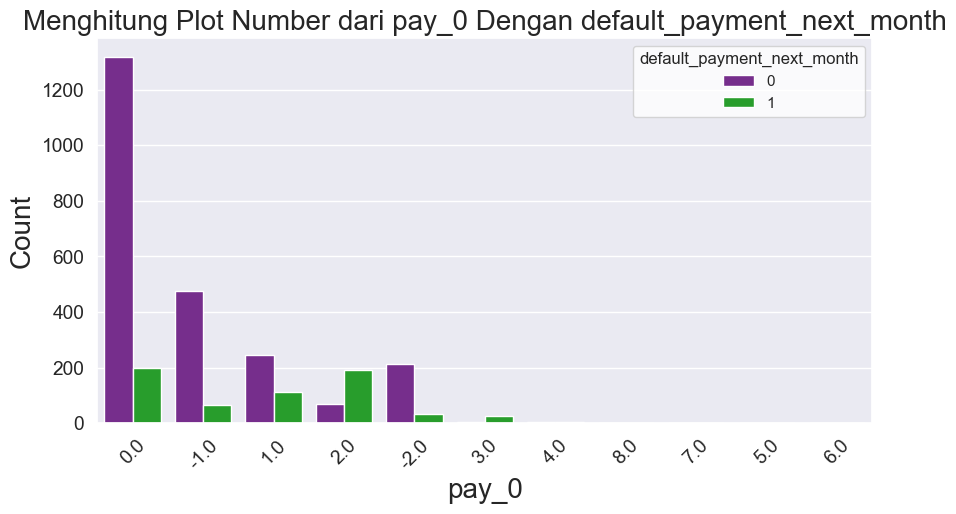

In [67]:
#plot bar dari pay_0 dan jumlah default_payment_next_month
plotting_Profit('pay_0','default_payment_next_month') # Plot-1

* PAY_0: Riwayat status pelunasan sebelumnya, apakah dibayar tepat waktu atau keterlambatan pembayaran. PAY_0 = status pembayaran di bulan September. Skala (berlaku untuk PAY_0 hingga Pay_6): -1 = bayar dengan semestinya, 1 = penundaan pembayaran selama * 1 bulan, 2 = penundaan pembayaran selama 2 bulan, ... 9 = penundaan pembayaran selama 9 bulan atau lebih)
* -2 : Saldo telah dibayar dan belum ada transaksi untuk bulan tersebut, yaitu. tidak ada kredit yang harus dibayar
* -1 : Saldo telah dibayar penuh tetapi ada beberapa transaksi selama bulan tersebut yang tidak tercermin pada laporan tagihan saat ini
* 0 : Pelanggan telah membayar minimal jumlah minimum yang dipersyaratkan, namun masih ada sisa saldo yang harus dibayar
* 1-9 Ketika seorang pelanggan tidak membayar jumlah minimum yang disyaratkan, itu dianggap sebagai pembayaran yang terlewatkan untuk bulan itu. Angka 1-9 akan sesuai dengan bulan kumulatif dari pembayaran yang terlewatkan pada saat itu.

<AxesSubplot: xlabel='default_payment_next_month', ylabel='count'>

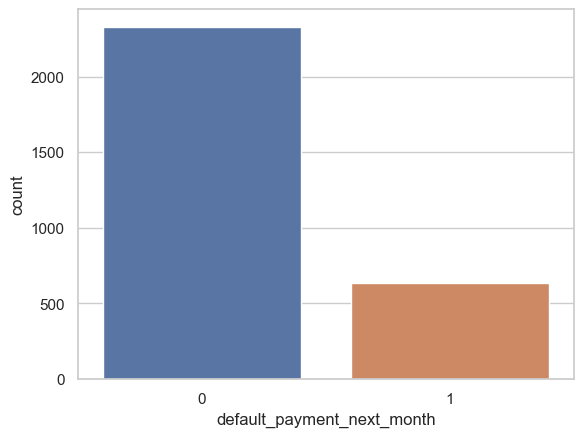

In [68]:
#melihat proporsi data dari target
sns.countplot(data=df,x='default_payment_next_month')

Dari gambar di atas disimpulkan bahwa kecenderunagan data tidak seimbang dengan jumlah yang membayar kredit (0) lebih banyak di bandingkan dengan jumlah yang tidak membayar kredit (1)

# v. Feature Engineering/Preprocessing

In [69]:
#menampilkan feature yang dipilih 
df.iloc[:,[0,4,7,8,13,14,19,20,24,25,26,27]]
df.head()

,limit_balance,sex,education_level,material_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month,sex_new,material_status_new,education_level_new,default_payment_next_month_new,age_group
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1,male,married,other,yes,50-59
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0,male,married,other,no,40-49
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1,female,single,other,yes,21-29
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0,female,single,other,no,30-39
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0,male,single,other,no,30-39


Dengan kolom di atas adalah kolom-kolom yang dipilih untuk feature yang mendukung dalam prediksi, kolom di atas diambil berdasarkan korelasi kolom dan target dan asumsi sendiri yang di asumsikan dalam prediksi yang akan di lakukan ketika input kondisi dengan ketentuan di atas dan menampilkan jumlah dari tagihan pembayaran serta membayar minimum pembayaran di setiap bulan maka akan di prediksi dengan kartu kredit dapat di lanjutkan (no=0)

In [70]:
# define feature and target
X = df.drop('default_payment_next_month_new', axis=1)
y = df['default_payment_next_month_new'].replace({'yes':1, 'no': 0})

X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, stratify=y,  random_state=13)

Memisahkan antara data train dan data test untuk dilakukan uji kinerja model pada data yang tidak dilihat sebelumnya (data test) dan memastikan bahwa model dapat melakukan prediksi yang akurat pada data baru. dapat kita ingat dalam EDA kita melihat bahwa informasi data yang terdapat dalam target inbalance maka solusinya ketika split data menggunakan *stratify=y* yaitu untuk membagi data menjadi train dan test set dapat membantu memastikan bahwa distribusi kelas yang tidak seimbang dipertahankan di kedua set.

In [71]:
#loop cek shape train & test
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(2371, 28)
(593, 28)
(2371,)
(593,)


Setelah data di split dapat terlihat 20% jumlah data test adalah 593 dan jumlah data train adalah 2371

In [72]:
#menggabungkan nilai X_train dan y_train
df_con = pd.concat([X_train, y_train], axis=1)

df_con.shape

(2371, 29)

In [73]:
num_col = X_train.iloc[:,[0,1,4,5,6,7,11]]
cat_col = X_train.iloc[:,[2,3,8,9,10]]

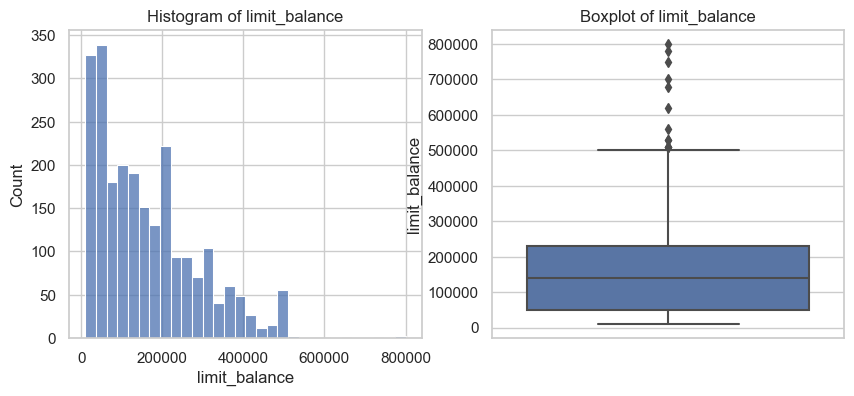


Skewness Value :  1.0006047564306488


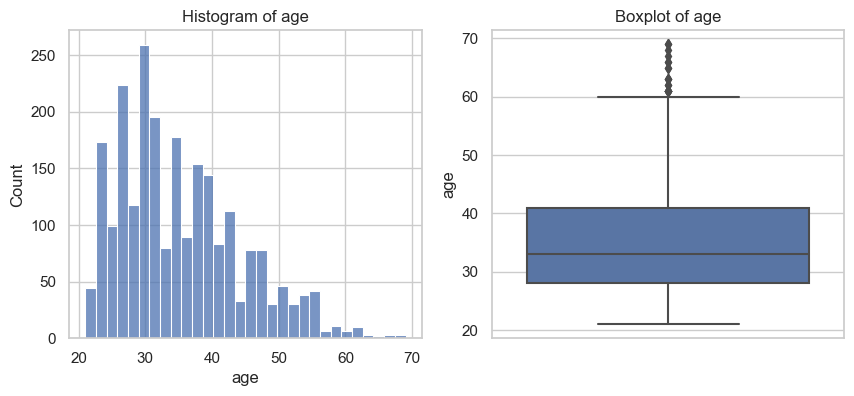


Skewness Value :  0.7726317877077615


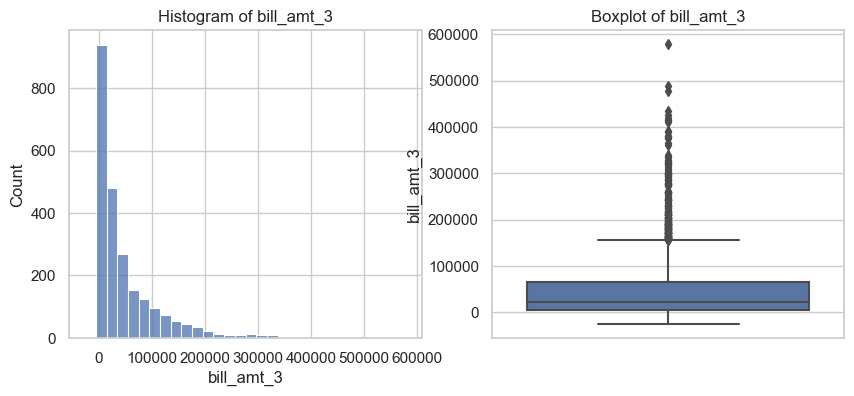


Skewness Value :  2.569558864308388


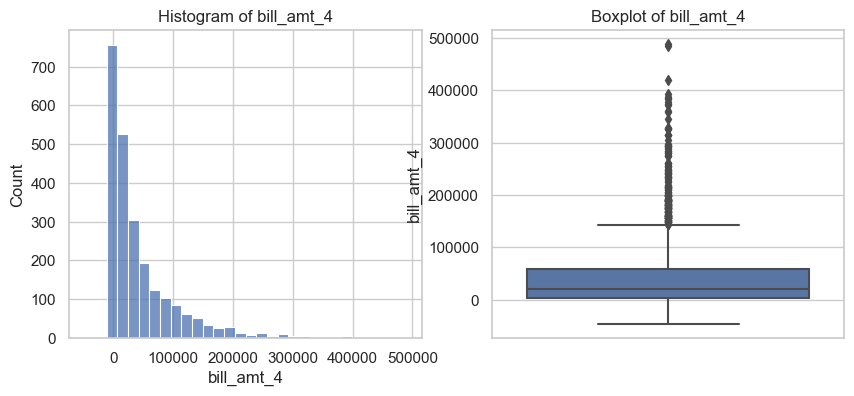


Skewness Value :  2.447791627637353


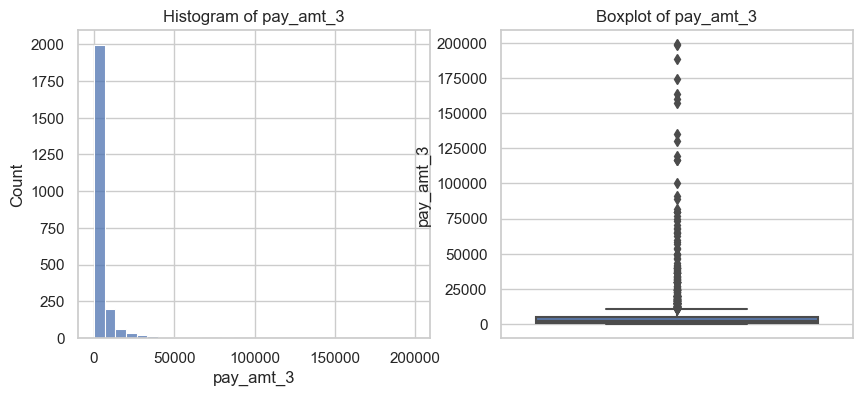


Skewness Value :  8.043463398022954


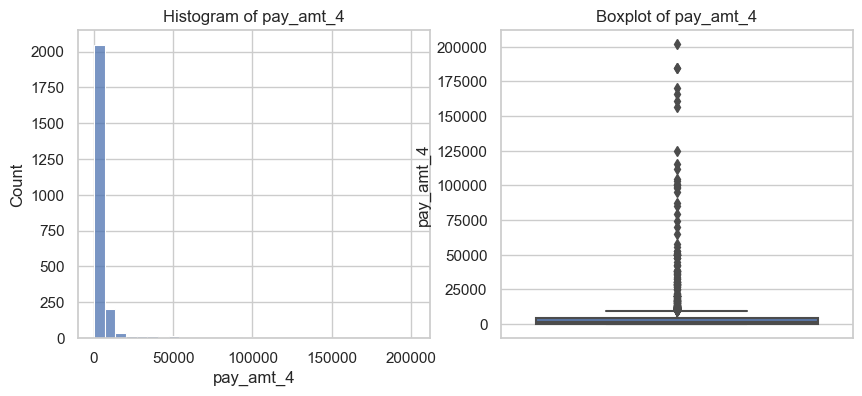


Skewness Value :  8.450287705274073


In [74]:
#melihat distribusi & outlier pada kolom numerik 
num_col_unclear = df_con[['limit_balance',
 'age',
 'bill_amt_3',
 'bill_amt_4',
 'pay_amt_3',
 'pay_amt_4',
 ]]

# looping num_col_unclear
for col in num_col_unclear:
    # Define figure size
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_con[col], bins=30)
    plt.title('Histogram of {}'.format(col))
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_con[col])
    plt.title('Boxplot of {}'.format(col))
    

    plt.show()
    # diagnostic_plots(num_col)
    print('\nSkewness Value : ', df[col].skew())

In [75]:
#melakukan perhitungan untuk distribusi normal dan tidak normal 
num_col = df_con[['limit_balance','age',
 'bill_amt_3',
 'bill_amt_4',
 'pay_amt_3',
 'pay_amt_4'
  ]]

for col in num_col.columns: 
  skewness = num_col[col].skew()
  if skewness>=-0.5 and skewness<=0.5: #Gaussian distribusion / distribusi normal
    upper = num_col[col].mean() + 3*num_col[col].std() 
    lower = num_col[col].mean() - 3*num_col[col].std()
  elif skewness>=-1 and skewness<=1:
    Q1 = num_col[col].quantile(0.25)
    Q3 = num_col[col].quantile(0.75)
    IQR = Q3 - Q1 #tukey roles / distribusi tidak normal
    upper = Q3 + 1.5*IQR
    lower = Q1 - 1.5*IQR    
  else:
    Q1 = num_col[col].quantile(0.25)
    Q3 = num_col[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 3*IQR
    lower = Q1 - 3*IQR
  
  no_outliers_num = num_col[(num_col[col]>=lower) & (num_col[col]<=upper)] #data yang sudah di hilangkan ouliernya 
  outliers = num_col[(num_col[col]<lower) | (num_col[col]>upper)] #data dengan oulier

 

data di atas adalah untuk mecari outlier dengan perhitungan dari ilai skew jika nilai skew nya -0.5 - 0.5 maka akan di lakukan dengan gausian distribussion/distribusi normal dan jika skewnya rentang -1 - 1 maka di lakukan dengan metode IQR.

In [76]:
#row oulier
outliers

,limit_balance,age,bill_amt_3,bill_amt_4,pay_amt_3,pay_amt_4
2020,140000.0,26.0,41266.0,39634.0,11888.0,115440.0
2023,100000.0,26.0,25669.0,881.0,2007.0,57500.0
2598,180000.0,39.0,-6674.0,18084.0,36550.0,16481.0
2406,390000.0,33.0,7599.0,2947.0,2947.0,87476.0
1935,150000.0,52.0,150080.0,47214.0,0.0,98828.0
...,...,...,...,...,...,...
136,500000.0,44.0,96617.0,97437.0,17446.0,100000.0
2098,150000.0,30.0,2700.0,1500.0,0.0,18439.0
2309,310000.0,42.0,17257.0,7900.0,4.0,17161.0
377,200000.0,31.0,72912.0,80819.0,10000.0,20000.0


data diatas adalah row otlier dari hasil perhitungan gausiian distribussion dan IQR distribussion. dalam handling outlier akan menggunakan winsorizer dalam pipline dibawah.

In [77]:
#% outlier
len(outliers)/len(num_col)

0.04723745255166596

In [78]:
#drop indexoutlier pada kategorikal dan 
cat_col.drop(list(outliers.index),inplace=True)
df_con.drop(list(outliers.index),inplace=True)

### Pipeline

In [79]:
#pipline scaler
num_pipeline = Pipeline([
        ('outlier', Winsorizer(capping_method='iqr', tail='both', fold=3)), #Winsorizer akan mengambil data yang berada di luar range IQR 
        ('imputer', SimpleImputer(strategy='median')), #mengisi missing values dengan nilai yang diambil dari nilai median
        ('scaler',  MinMaxScaler()) # scala dengandistribusi tidak normal 
    ])

num_tr = num_pipeline.fit_transform(X_train[['limit_balance','age',	
 'bill_amt_3',
 'bill_amt_4',
 'pay_amt_3',
 'pay_amt_4']])
num_tr

array([[0.39473684, 0.10416667, 0.09322375, 0.16948647, 0.        ,
        0.        ],
       [0.25      , 0.54166667, 0.09577392, 0.17201639, 0.04028244,
        0.05565789],
       [0.14473684, 0.125     , 0.09465272, 0.17232173, 0.04514411,
        0.        ],
       ...,
       [0.15789474, 0.6875    , 0.20851959, 0.1678871 , 0.        ,
        0.01315789],
       [0.07894737, 0.3125    , 0.16397605, 0.24226166, 0.0774974 ,
        0.16401316],
       [0.01315789, 0.02083333, 0.09688045, 0.17215452, 0.04259752,
        0.11835526]])

 * MinMaxScaler Scaling mengurangi pengaruh dari data yang memiliki nilai ekstrem atau outliers pada normalisasi data,biasanya digunakan pada algoritma mechine learning yang sensitif terhadap skala data, seperti algoritma berbasis jarak (seperti K-Nearest Neighbors), algoritma berbasis gradient (seperti regresi logistik), dan algoritma berbasis kernel (seperti SVM).
 * Winsorizer menggunakan metode capping (atau pengubahan nilai) pada data yang berada di luar range tertentu. Dalam hal ini, metode capping yang digunakan adalah IQR (Interquartile Range) yang menghitung rentang antara kuartil ke-1 dan kuartil ke-3 dari data.
 * SimpleImputer digunakan untuk mengisi missing values dengan nilai yang diambil dari nilai median


In [80]:
#pipline ordinal encodeing
cat_1_pipeline = Pipeline([
        ('imputer_1', SimpleImputer(strategy='most_frequent')),
        ('ordinal_enc', OrdinalEncoder(categories='auto',handle_unknown='use_encoded_value', unknown_value=100)) 
    ])

cat_1_tr = cat_1_pipeline.fit_transform(X_train[['material_status_new','education_level_new','pay_3','pay_4']]) #fit xtrain categ
cat_1_tr

array([[2., 3., 0., 0.],
       [2., 3., 1., 1.],
       [0., 1., 1., 1.],
       ...,
       [2., 0., 2., 2.],
       [0., 3., 3., 2.],
       [2., 0., 0., 0.]])

Ordinal encoding adalah teknik representasi data kategorikalyang disesuaikan dengan urutan kategorinya atau sederhananya kategorikal yang memiliki tingkatan level. age dan education adalah kolom kategorikal dengan kategori yang akan di encode menggunakan OrdinalEncoder.

In [81]:
#pipline ohe encoding
cat_2_pipeline = Pipeline([
        ('imputer_2', SimpleImputer(strategy='most_frequent')),
        ('ohe_enc', OneHotEncoder(sparse=False, handle_unknown='ignore')) # sex_new
    ])

cat_2_tr = cat_2_pipeline.fit_transform(X_train[['sex_new']])
cat_2_tr

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

One-hot encoding adalah teknik representasi data kategorikal menjadi vektor numerik biner yang dapat digunakan sebagai input untuk model machine learning. kolom workclass occupation sex adalah  feature categorical dari data yang akan di encoding dengan OHE.

In [82]:
#menggabungkan scaler & ordinal dalam 1 variable 
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, ['limit_balance','age',
 'bill_amt_3',
 'bill_amt_4',
 'pay_amt_3',
 'pay_amt_4']),
        ("cat_ord", cat_1_pipeline, ['material_status_new','education_level_new','pay_3','pay_4']),
        ("cat_ohe", cat_2_pipeline, ['sex_new'])
    ])
#final x_train
train_final = full_pipeline.fit_transform(X_train)
train_final

array([[0.39473684, 0.10416667, 0.09322375, ..., 0.        , 1.        ,
        0.        ],
       [0.25      , 0.54166667, 0.09577392, ..., 1.        , 0.        ,
        1.        ],
       [0.14473684, 0.125     , 0.09465272, ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.15789474, 0.6875    , 0.20851959, ..., 2.        , 0.        ,
        1.        ],
       [0.07894737, 0.3125    , 0.16397605, ..., 2.        , 1.        ,
        0.        ],
       [0.01315789, 0.02083333, 0.09688045, ..., 0.        , 0.        ,
        1.        ]])

menggabungkan 3 part dalam scala ,ohe enc dan ord enc dalam full_pipeline

In [83]:
#final test 
test_final = full_pipeline.transform(X_test)
test_final

array([[0.09210526, 0.16666667, 0.17089006, ..., 3.        , 1.        ,
        0.        ],
       [0.44736842, 0.25      , 0.09314315, ..., 0.        , 0.        ,
        1.        ],
       [0.64473684, 0.41666667, 0.77026938, ..., 2.        , 0.        ,
        1.        ],
       ...,
       [0.47368421, 0.41666667, 0.09322375, ..., 0.        , 0.        ,
        1.        ],
       [0.52631579, 0.4375    , 0.11724876, ..., 1.        , 0.        ,
        1.        ],
       [0.43421053, 0.47916667, 0.63067008, ..., 2.        , 1.        ,
        0.        ]])

# vi. Model Definition

In [84]:
# Defining Classifier Model
logreg = LogisticRegression(random_state=42)
# inisialisasi model SVC
svc = SVC()
# inisialisasi model DTC
dtc = DecisionTreeClassifier(criterion='gini', random_state=42)
## inisialisasi model dengan 100 pohon dan kedalaman maksimum 5
rfc = RandomForestClassifier(n_estimators=100,max_depth=5, random_state=42)
# inisialisasi model dengan 5 tetangga terdekat
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
# inisialisasi model GaussianNB
nb = GaussianNB()
# inisialisasi model ada
ada = AdaBoostClassifier()

* Logistic regression merupakan algoritma pembelajaran mesin yang digunakan untuk memprediksi nilai output dalam bentuk probabilitas.
* SVM digunakan untuk memisahkan data ke dalam dua kelas yang berbeda (binary classification), dengan menemukan hyperplane yang memaksimalkan margin (jarak) antara kelas-kelas tersebut.
* Decision tree melakukan klasifikasi pada data dengan banyak kelas (multi-class classification) maupun hanya dua kelas (binary classification), tergantung pada jumlah output node pada pohon keputusan. 
* Randomfores mengambil sampel acak dari data training untuk membuat sejumlah pohon keputusan, dan kemudian hasil klasifikasi dari masing-masing pohon digabungkan untuk menghasilkan prediksi akhir.
* knn melakukan klasifikasi pada data dengan menghitung jarak antara data baru dengan data training yang ada, dan kemudian menentukan kelas terdekat dari data baru berdasarkan sejumlah tetangga terdekat yang telah ditentukan sebelumnya (parameter k).
* nb Model ini mengasumsikan bahwa setiap fitur pada data berdistribusi normal (Gaussian), dan kemudian menggunakan teori probabilitas untuk menentukan kelas yang paling mungkin dari data baru.
* melakukan klasifikasi pada data dengan menggunakan metode ensemble learning yang menggabungkan beberapa model base (misalnya decision tree atau logistic regression) dengan memberikan bobot yang berbeda pada setiap model. 

# vii. Model Training

In [85]:
# inisiasi Classifier Model
logreg.fit(train_final, y_train) #fit train

lr_train = logreg.predict(train_final) #predik
lr_test = logreg.predict(test_final)

print(classification_report(y_train, lr_train)) #hasil predik
print(classification_report(y_test, lr_test))


              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1863
           1       0.70      0.06      0.11       508

    accuracy                           0.79      2371
   macro avg       0.75      0.53      0.50      2371
weighted avg       0.77      0.79      0.72      2371

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       466
           1       0.62      0.04      0.07       127

    accuracy                           0.79       593
   macro avg       0.71      0.52      0.48       593
weighted avg       0.76      0.79      0.71       593



dari classification report diatas dapat kita lihat antara prediksi probabilitas dari data train dan test. 

    *kelas 0* 
* pada data train kelas 0 : precision : 0.79 recall:  0.99  f1-score : 0.88   support 1764
* pada data test kelas 0 :  precision : 0.79 recall:  0.99  f1-score : 0.88   support 442

    *kelas 1* 
* pada data train kelas 1: precision : 0.72 recall: 0.06  f1-score :  0.12 support 497
* pada data test kelas 1:  precision : 0.50 recall: 0.04  f1-score : 0.07  support 124


nilai kelas 0 : dari prediksi probabilitas data, pada Data train  dan pada data test model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting 

nilai kelas 1 : Model memiliki tingkat recall yang lebih rendah untuk kelas 1 dengan nilai 0,06, yang menunjukkan bahwa model kesulitan memprediksi label kelas 1. Kedua set data memiliki kelas yang tidak seimbang dengan jumlah sampel yang lebih banyak pada kelas 0 daripada kelas 1. Hal ini dapat mempengaruhi performa model karena model cenderung memprediksi label kelas mayoritas dan dapat menghasilkan tingkat recall yang rendah untuk kelas minoritas. Nilai f1-score yang lebih rendah pada kelas 1 juga menunjukkan bahwa model memiliki kesulitan dalam memprediksi label pada kelas minoritas.

Nilai accuracy menunjukkan seberapa banyak kasus yang berhasil diidentifikasi dengan benar oleh model, sedangkan macro average dan weighted average adalah rata-rata dari precision, recall, dan f1-score untuk seluruh kelas.

In [86]:
# inisialisasi model SVC
svc.fit(train_final, y_train) #fit train 

svc_train = svc.predict(train_final) #predik
svc_test = svc.predict(test_final)

print(classification_report(y_train, svc_train)) #hasil predik
print(classification_report(y_test, svc_test))


              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1863
           1       0.72      0.24      0.36       508

    accuracy                           0.82      2371
   macro avg       0.77      0.61      0.63      2371
weighted avg       0.80      0.82      0.78      2371

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       466
           1       0.64      0.24      0.34       127

    accuracy                           0.81       593
   macro avg       0.73      0.60      0.62       593
weighted avg       0.78      0.81      0.77       593



dari classification report diatas dapat kita lihat antara prediksi probabilitas dari data train dan test. 

    *kelas 0* 
* pada data train kelas 0 :  precision : 0.82   recall:  0.97  f1-score : 0.89  support 1764
* pada data test kelas 0 :   precision : 0.82   recall:  0.97  f1-score : 0.89  support 442  

    *kelas 1* 
* pada data train kelas 1 :  precision : 0.69 recall: 0.24  f1-score : 0.36 support 497  
* pada data test kelas 1  :  precision : 0.69 recall: 0.25 f1-score : 0.37 support 124 

nilai kelas 0 : dari prediksi probabilitas data, pada Data train  dan pada data test model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting 

nilai kelas 1 : Model memiliki tingkat recall yang lebih rendah untuk kelas 1 dengan nilai 0,24, yang menunjukkan bahwa model kesulitan memprediksi label kelas 1. Kedua set data memiliki kelas yang tidak seimbang dengan jumlah sampel yang lebih banyak pada kelas 0 daripada kelas 1. Hal ini dapat mempengaruhi performa model karena model cenderung memprediksi label kelas mayoritas dan dapat menghasilkan tingkat recall yang rendah untuk kelas minoritas. Nilai f1-score yang lebih rendah pada kelas 1 juga menunjukkan bahwa model memiliki kesulitan dalam memprediksi label pada kelas minoritas.

Nilai accuracy menunjukkan seberapa banyak kasus yang berhasil diidentifikasi dengan benar oleh model, sedangkan macro average dan weighted average adalah rata-rata dari precision, recall, dan f1-score untuk seluruh kelas.

In [87]:
# inisialisasi model decissiontree
dtc.fit(train_final, y_train) #fit train

dtc_train = dtc.predict(train_final) #predik 
dtc_test = dtc.predict(test_final)

print(classification_report(y_train, dtc_train)) #hasil predik
print(classification_report(y_test, dtc_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1863
           1       1.00      1.00      1.00       508

    accuracy                           1.00      2371
   macro avg       1.00      1.00      1.00      2371
weighted avg       1.00      1.00      1.00      2371

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       466
           1       0.27      0.31      0.29       127

    accuracy                           0.67       593
   macro avg       0.54      0.54      0.54       593
weighted avg       0.69      0.67      0.68       593



dari classification report diatas dapat kita lihat antara prediksi probabilitas dari data train dan test. 

    *kelas 0* 
* pada data train kelas 0 : precision : 1.00  recall: 1.00  f1-score : 1.00 support 1764 
* pada data test kelas 0 :  precision : 0.81   recall: 0.84  f1-score : 0.82  support 442 

    *kelas 0/<=50* 
* pada data train kelas 1 :   precision : 1.00  recall: 1.00  f1-score : 1.00  support  497 
* pada data test kelas 1  :  precision :  0.35   recall: 0.31  f1-score : 0.33    support 124

nilai kelas 0 : dari prediksi probabilitas data, pada Data train  dan pada data test model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting 

nilai kelas 1 : bahwa model yang digunakan mungkin overfit pada data train, sehingga tidak mampu melakukan generalisasi dengan baik pada data test yang belum pernah dilihat sebelumnya. Hal ini dapat disebabkan oleh beberapa faktor, seperti ukuran dataset yang terlalu kecil atau sample yang di gunakan dalam pelatihan data sangat kecil sehingga model tidak dapat mengeneralisasi dengan baik, dalam improvement yang dapat di gunakan salah satunya adalah Meningkatkan jumlah data train.

Nilai accuracy menunjukkan seberapa banyak kasus yang berhasil diidentifikasi dengan benar oleh model, sedangkan macro average dan weighted average adalah rata-rata dari precision, recall, dan f1-score untuk seluruh kelas.

In [88]:
## inisialisasi model Rfc
rfc.fit(train_final, y_train) #fit train

rfc_train = rfc.predict(train_final) #predik
rfc_test = rfc.predict(test_final)

print(classification_report(y_train, rfc_train)) #hasilpredik
print(classification_report(y_test, rfc_test))


              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1863
           1       0.75      0.28      0.40       508

    accuracy                           0.82      2371
   macro avg       0.79      0.63      0.65      2371
weighted avg       0.81      0.82      0.79      2371

              precision    recall  f1-score   support

           0       0.82      0.96      0.89       466
           1       0.61      0.24      0.34       127

    accuracy                           0.80       593
   macro avg       0.72      0.60      0.61       593
weighted avg       0.78      0.80      0.77       593



dari classification report diatas dapat kita lihat antara prediksi probabilitas dari data train dan test. 

    *kelas 0* 
* pada data train kelas 0 : precision : 1.00  recall: 1.00  f1-score : 1.00 support 1764 
* pada data test kelas 0 :  precision : 0.81   recall: 0.94  f1-score : 0.87  support 442

    *kelas 0/<=50* 
* pada data train kelas 1 :  precision : 1.00  recall: 1.00  f1-score : 1.00  support  497 
* pada data test kelas 1  :  precision : 0.52    recall: 0.22   f1-score : 0.31  support 124

nilai kelas 0 : dari prediksi probabilitas data, pada Data train  dan pada data test model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting 

nilai kelas 1 : bahwa model yang digunakan overfit pada data train, sehingga tidak mampu melakukan generalisasi dengan baik pada data test yang belum pernah dilihat sebelumnya. Hal ini dapat disebabkan oleh beberapa faktor, seperti ukuran dataset yang terlalu kecil atau sample yang di gunakan dalam pelatihan data sangat kecil sehingga model tidak dapat mengeneralisasi dengan baik, dalam improvement yang dapat di gunakan salah satunya adalah Meningkatkan jumlah data train.

Nilai accuracy menunjukkan seberapa banyak kasus yang berhasil diidentifikasi dengan benar oleh model, sedangkan macro average dan weighted average adalah rata-rata dari precision, recall, dan f1-score untuk seluruh kelas.

In [89]:
# inisialisasi model knn
knn.fit(train_final, y_train) #fit train

knn_train = knn.predict(train_final) # predik
knn_test = knn.predict(test_final)

print(classification_report(y_train, knn_train)) #hasil predik
print(classification_report(y_test, knn_test))


              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1863
           1       0.68      0.40      0.50       508

    accuracy                           0.83      2371
   macro avg       0.77      0.67      0.70      2371
weighted avg       0.82      0.83      0.81      2371

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       466
           1       0.47      0.27      0.34       127

    accuracy                           0.78       593
   macro avg       0.64      0.59      0.60       593
weighted avg       0.75      0.78      0.75       593



dari classification report diatas dapat kita lihat antara prediksi probabilitas dari data train dan test. 

    *kelas 0* 
* pada data train kelas 0 : precision : 0.85    recall: 0.95  f1-score : 0.90 support 1764
* pada data test kelas 0 :  precision : 0.82 recall: 0.92  f1-score : 0.87 support 442

    *kelas 1* 
* pada data train kelas 1 :  precision : 0.69    recall:  0.40 f1-score : 0.49  support 497
* pada data test kelas 1  :  precision : 0.51    recall: 0.27  f1-score : 0.38  support 124

nilai kelas 0 : dari prediksi probabilitas data, pada Data train  dan pada data test model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting 

nilai kelas 1 : bahwa model yang digunakan mungkin overfit pada data train, sehingga tidak mampu melakukan generalisasi dengan baik pada data test yang belum pernah dilihat sebelumnya. Hal ini dapat disebabkan oleh beberapa faktor, seperti ukuran dataset yang terlalu kecil atau sample yang di gunakan dalam pelatihan data sangat kecil sehingga model tidak dapat mengeneralisasi dengan baik, dalam improvement yang dapat di gunakan salah satunya adalah Meningkatkan jumlah data train.

Nilai accuracy menunjukkan seberapa banyak kasus yang berhasil diidentifikasi dengan benar oleh model, sedangkan macro average dan weighted average adalah rata-rata dari precision, recall, dan f1-score untuk seluruh kelas.

In [90]:
# inisialisasi model nb
nb.fit(train_final, y_train) #fit train

nb_train = nb.predict(train_final) #predik
nb_test = nb.predict(test_final)

print(classification_report(y_train, nb_train)) #hasil predik
print(classification_report(y_test, nb_test))


              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1863
           1       0.56      0.35      0.43       508

    accuracy                           0.80      2371
   macro avg       0.70      0.64      0.66      2371
weighted avg       0.78      0.80      0.78      2371

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       466
           1       0.53      0.35      0.42       127

    accuracy                           0.79       593
   macro avg       0.68      0.63      0.65       593
weighted avg       0.77      0.79      0.78       593



dari classification report diatas dapat kita lihat antara prediksi probabilitas dari data train dan test. 

    *kelas 0* 
* pada data train kelas 0 : precision : 0.85     recall: 0.75  f1-score : 0.80   support 1764
* pada data test kelas 0 :  precision : 0.85    recall: 0.73  f1-score : 0.78    support  442

    *kelas 0/<=50* 
* pada data train kelas 1 :  precision : 0.38     recall: 0.54   f1-score : 0.45 support 497   
* pada data test kelas 1  :  precision : 0.35    recall:  0.53   f1-score :  0.43  support 124 

nilai kelas 0 : dari prediksi probabilitas data, pada Data train  dan pada data test model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting 

nilai kelas 1 : Model memiliki tingkat recall yang lebih rendah untuk kelas 1 dengan nilai 0,35, yang menunjukkan bahwa model kesulitan memprediksi label kelas 1. Kedua set data memiliki kelas yang tidak seimbang dengan jumlah sampel yang lebih banyak pada kelas 0 daripada kelas 1. Hal ini dapat mempengaruhi performa model karena model cenderung memprediksi label kelas mayoritas dan dapat menghasilkan tingkat recall yang rendah untuk kelas minoritas. Nilai f1-score yang lebih rendah pada kelas 1 juga menunjukkan bahwa model memiliki kesulitan dalam memprediksi label pada kelas minoritas.

Nilai accuracy menunjukkan seberapa banyak kasus yang berhasil diidentifikasi dengan benar oleh model, sedangkan macro average dan weighted average adalah rata-rata dari precision, recall, dan f1-score untuk seluruh kelas.

## Other Algorithm

In [91]:
# inisialisasi model ada
ada.fit(train_final, y_train) #fit train 

ada_train = ada.predict(train_final) #predik
ada_test = ada.predict(test_final)

print(classification_report(y_train, ada_train)) #hasil predik
print(classification_report(y_test, ada_test))


              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1863
           1       0.69      0.30      0.42       508

    accuracy                           0.82      2371
   macro avg       0.76      0.63      0.66      2371
weighted avg       0.80      0.82      0.79      2371

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       466
           1       0.62      0.28      0.39       127

    accuracy                           0.81       593
   macro avg       0.73      0.62      0.64       593
weighted avg       0.79      0.81      0.78       593



dari classification report diatas dapat kita lihat antara prediksi probabilitas dari data train dan test. 

    *kelas 0* 
* pada data train kelas 0 : precision : 0.83   recall: 0.964  f1-score : 0.89  support 1764 
* pada data test kelas 0 :  precision : 0.82   recall: 0.95   f1-score : 0.88  support  442

    *kelas 0/<=50* 
* pada data train kelas 1 :  precision : 0.66   recall: 0.29  f1-score : 0.40   support 497 
* pada data test kelas 1  :  precision : 0.60   recall: 0.24  f1-score : 0.34   support 124

nilai kelas 0 : dari prediksi probabilitas data, pada Data train  dan pada data test model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting 

nilai kelas 1 : Model memiliki tingkat recall yang lebih rendah untuk kelas 1 dengan nilai 0,30, yang menunjukkan bahwa model kesulitan memprediksi label kelas 1. Kedua set data memiliki kelas yang tidak seimbang dengan jumlah sampel yang lebih banyak pada kelas 0 daripada kelas 1. Hal ini dapat mempengaruhi performa model karena model cenderung memprediksi label kelas mayoritas dan dapat menghasilkan tingkat recall yang rendah untuk kelas minoritas. Nilai f1-score yang lebih rendah pada kelas 1 juga menunjukkan bahwa model memiliki kesulitan dalam memprediksi label pada kelas minoritas.

Nilai accuracy menunjukkan seberapa banyak kasus yang berhasil diidentifikasi dengan benar oleh model, sedangkan macro average dan weighted average adalah rata-rata dari precision, recall, dan f1-score untuk seluruh kelas.

# viii. Model Evaluation (Cross Validation)

In [93]:
skfold=StratifiedKFold(n_splits=5) # jumlah fold (n_splits) sebanyak 5
# checking cross validation score 
cv_logreg_model = cross_val_score(logreg, train_final, y_train, cv=skfold, scoring="recall")
cv_svc_model = cross_val_score(svc, train_final, y_train, cv=skfold, scoring="recall")
cv_dtc_model = cross_val_score(dtc, train_final, y_train, cv=skfold, scoring="recall")
cv_rfc_model = cross_val_score(rfc, train_final, y_train, cv=skfold, scoring="recall")
cv_knn_model = cross_val_score(knn, train_final, y_train, cv=skfold, scoring="recall")
cv_nb_model = cross_val_score(nb, train_final, y_train, cv=skfold, scoring="recall")
cv_ada_model = cross_val_score(ada, train_final, y_train, cv=skfold, scoring="recall")
name_model = []
cv_scores=0
#loop dengan zip  menggabungkan beberapa iterables menjadi sebuah iterable tunggal
for cv,name in zip([cv_logreg_model,cv_svc_model,cv_dtc_model,cv_rfc_model,cv_knn_model,cv_nb_model],['logreg','svc','dtc','rfc','knn','nb']): 
    print(name)
    print('recall - All - Cross Validation  : ', cv)
    print('recall - Mean - Cross Validation : ', cv.mean())
    print('recall - Std - Cross Validation  : ', cv.std())
    print('recall - Range of Test-Set       : ', (cv.mean()-cv.std()) , '-', (cv.mean()+cv.std()))
    print('-'*50)
    if cv.mean()>cv_scores:
        cv_scores = cv.mean()
        name_model = name
    else:
        pass
print('best model:', name_model)
print('cross-val mean:', cv_scores)

logreg
recall - All - Cross Validation  :  [0.03921569 0.03960396 0.07920792 0.04901961 0.06862745]
recall - Mean - Cross Validation :  0.055134925257231605
recall - Std - Cross Validation  :  0.016084697763990827
recall - Range of Test-Set       :  0.039050227493240774 - 0.07121962302122244
--------------------------------------------------
svc
recall - All - Cross Validation  :  [0.2254902  0.1980198  0.28712871 0.17647059 0.26470588]
recall - Mean - Cross Validation :  0.23036303630363036
recall - Std - Cross Validation  :  0.040929203383671085
recall - Range of Test-Set       :  0.18943383291995927 - 0.27129223968730143
--------------------------------------------------
dtc
recall - All - Cross Validation  :  [0.32352941 0.30693069 0.36633663 0.29411765 0.33333333]
recall - Mean - Cross Validation :  0.3248495437779072
recall - Std - Cross Validation  :  0.02474037488635421
recall - Range of Test-Set       :  0.300109168891553 - 0.3495899186642614
----------------------------------

Cross validation Metrik yang digunakan untuk evaluasi adalah recall, dan skema cross-validation yang digunakan adalah Stratified K-Fold.
Pada setiap iterasi, code akan menghitung nilai recall pada data train yang dipartisi menggunakan skema Stratified K-Fold. Setelah selesai melakukan cross validation pada masing-masing model, code akan menampilkan nilai recall rata-rata dan standar deviasi pada setiap fold, serta menampilkan rentang nilai recall yang dihasilkan pada setiap model.juga membandingkan nilai recall rata-rata dari semua model dan memilih model yang memiliki nilai recall rata-rata tertinggi sebagai model terbaik. dari data di atas dapat kita lihat best model dari hasil prediksi adalah nb dengan nilai cross-val mean: 0.34. namun dalam hal ini NB cenderung tidak efektif pada dataset yang tidak seimbang, di mana jumlah sampel pada setiap kelas tidak seimbang dan Model GaussianNB tidak memiliki hyperparameter yang signifikan yang dapat diatur secara manual ini adalah alasan tidak di lanjutkan lebih lanjut dalam pemodelan prediksi.

## Secon base best model

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1863
           1       0.77      0.27      0.40       508

    accuracy                           0.83      2371
   macro avg       0.80      0.62      0.65      2371
weighted avg       0.82      0.83      0.79      2371

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       466
           1       0.58      0.24      0.34       127

    accuracy                           0.80       593
   macro avg       0.70      0.59      0.61       593
weighted avg       0.77      0.80      0.76       593



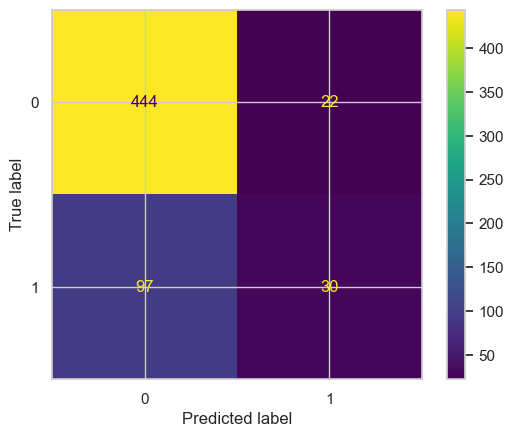

In [94]:
#linear kernel and regularization parameter C=1
svm_tunning = SVC(kernel='poly', gamma='scale', C=4.0, coef0=0.01, degree= 5, max_iter= -1, shrinking=True, 
                    probability=False, tol=1e-3, decision_function_shape='ovr', 
                    break_ties=False, random_state=42, class_weight=None) #syarat hitung predic proba  RUC membedakan 
svm_tunning.fit(train_final, y_train) #train aja yang difit

svm_train = svm_tunning.predict(train_final)
svm_test = svm_tunning.predict(test_final)

print(classification_report(y_train, svm_train))
print(classification_report(y_test, svm_test))


cm = confusion_matrix(y_test, svm_test, labels= svm_tunning.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm_tunning.classes_)

disp.plot()
plt.show()


dari classification report diatas dapat kita lihat antara prediksi probabilitas dari data train dan test. 

    *kelas 0* 
* pada data train kelas 0 : precision : 0.82    recall: 0.96  f1-score : 0.89 support 1764
* pada data test kelas 0 :  precision : 0.82   recall:  0.97  f1-score : 0.89   support 442

    *kelas 0/<=50* 
* pada data train kelas 1 :  precision : 0.67 recall: 0.27 f1-score : 0.40  support 497  
* pada data test kelas 1  :  precision : 0.70 recall:  0.24 f1-score : 0.34    support 124

nilai kelas 0 : dari prediksi probabilitas data, pada Data train  dan pada data test model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting 

nilai kelas 1 : Model memiliki tingkat recall yang lebih rendah untuk kelas 1 dengan nilai 0.27, yang menunjukkan bahwa model kesulitan memprediksi label kelas 1. Kedua set data memiliki kelas yang tidak seimbang dengan jumlah sampel yang lebih banyak pada kelas 0 daripada kelas 1. Hal ini dapat mempengaruhi performa model karena model cenderung memprediksi label kelas mayoritas dan dapat menghasilkan tingkat recall yang rendah untuk kelas minoritas. Nilai f1-score yang lebih rendah pada kelas 1 juga menunjukkan bahwa model memiliki kesulitan dalam memprediksi label pada kelas minoritas.

Nilai accuracy menunjukkan seberapa banyak kasus yang berhasil diidentifikasi dengan benar oleh model, sedangkan macro average dan weighted average adalah rata-rata dari precision, recall, dan f1-score untuk seluruh kelas.

## Hyperparameter Tuning

In [98]:
# melakukan hyperparameter tunning
params = [
    {'C': [1.0, 2.0, 3.0, 4.0],        # 4
     'max_iter': [-1,-2,-3, -4],            # 4
     'coef0': [0.0, 0.01, None],              # 3
     'degree': [3, 4, 5],
     'kernel': ['rbf','poly','linear','sigmoid']
      },       # 2   Total 4*4*3*2 = 96 combinations
  ]


svm = SVC( gamma = 'scale' , shrinking=True, 
                    probability=False, tol=1e-3, decision_function_shape='ovr', 
                    break_ties=False, random_state=None, class_weight=None)

grid_search = GridSearchCV(svm, params, cv=5,
                           scoring='recall',
                           return_train_score=True)
grid_search.fit(train_final, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1.0, 2.0, 3.0, 4.0], 'coef0': [0.0, 0.01, None],
                          'degree': [3, 4, 5],
                          'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
                          'max_iter': [-1, -2, -3, -4]}],
             return_train_score=True, scoring='recall')

In [99]:
grid_search.best_params_

{'C': 4.0, 'coef0': 0.01, 'degree': 5, 'kernel': 'poly', 'max_iter': -1}

In [100]:
grid_search.best_score_

0.2481071636575422

In [101]:
#membuat model prediksi dengan dengan variabel baru sesudah di tunning
model = grid_search.best_estimator_

model.fit(train_final, y_train)

model_train = model.predict(train_final)
model_test = model.predict(test_final)

print(classification_report(y_train, model_train))
print(classification_report(y_test, model_test))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1863
           1       0.77      0.27      0.40       508

    accuracy                           0.83      2371
   macro avg       0.80      0.62      0.65      2371
weighted avg       0.82      0.83      0.79      2371

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       466
           1       0.58      0.24      0.34       127

    accuracy                           0.80       593
   macro avg       0.70      0.59      0.61       593
weighted avg       0.77      0.80      0.76       593



nilai kelas 0 : dari prediksi probabilitas data, pada Data train  dan pada data test model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting 

nilai kelas 1 : Model memiliki tingkat recall yang lebih rendah untuk kelas 1 dengan nilai 0.27, yang menunjukkan bahwa model kesulitan memprediksi label kelas 1. Kedua set data memiliki kelas yang tidak seimbang dengan jumlah sampel yang lebih banyak pada kelas 0 daripada kelas 1. Hal ini dapat mempengaruhi performa model karena model cenderung memprediksi label kelas mayoritas dan dapat menghasilkan tingkat recall yang rendah untuk kelas minoritas. Nilai f1-score yang lebih rendah pada kelas 1 juga menunjukkan bahwa model memiliki kesulitan dalam memprediksi label pada kelas minoritas.

Nilai accuracy menunjukkan seberapa banyak kasus yang berhasil diidentifikasi dengan benar oleh model, sedangkan macro average dan weighted average adalah rata-rata dari precision, recall, dan f1-score untuk seluruh kelas.

sesudah dilakukan parameter tunning recall score meninggkat dari walaupun tidak signifikan.

# ix. Model Saving

In [106]:
# Simpan full pipeline ke dalam file model_full_pipeline.pkl
with open('model_full_pipeline.pkl', 'wb') as file1:
    pickle.dump(full_pipeline, file1)

# Simpan model logreg ke dalam file model_logreg.pkl
with open('model_logreg.pkl', 'wb') as file2:
    pickle.dump(logreg, file2)

# Simpan model svc ke dalam file model_svc.pkl
with open('model_svc.pkl', 'wb') as file3:
    pickle.dump(svc, file3)

# Simpan model dtc ke dalam file model_dtc.pkl
with open('model_dtc.pkl', 'wb') as file4:
    pickle.dump(dtc, file4)

# Simpan model rfc ke dalam file model_rfc.pkl
with open('model_rfc.pkl', 'wb') as file5:
    pickle.dump(rfc, file5)

# Simpan model knn ke dalam file model_knn.pkl
with open('model_knn.pkl', 'wb') as file6:
    pickle.dump(knn, file6)


# Simpan model nb ke dalam file model_nb.pkl
with open('model_nb.pkl', 'wb') as file7:
    pickle.dump(nb, file7)

# Simpan model ke dalam file model_model.pkl
with open('model_model.pkl', 'wb') as file8:
    pickle.dump(model, file8)



# x. Model Inference

# xi. Overall Analysis

* Dalam prediksi probabilitas dataset dilakukan uji coba dengan 7 jenis model evaluasi yaitu LogisticRegression, SVM, KNN, GausianNB, RandomForest,decisoinTree dengan menggunakan feature pendukung dari target yaitu default_payment_next_month_new yang ber informasi 1: gagal bayar dan 0: membayar. dengan feture kolom yang mendukung untuk prediksi adalah limit_balance	age	pay_3	pay_4	bill_amt_3	bill_amt_4	pay_amt_3	pay_amt_4	sex_new	material_status_new	education_level_new. kesimpulan yang bisa diambil dalam bisnis yang sudah di jabarkan pada objectiv di atas:

* Berdasarkan objectiv saya adalah sisi bank yang memiliki 2 kemungkinan yaitu 1: gagal bayar dan 0:membayar. dimana prediksi ini di ambil dari  recall score dengan pengertianmetrik yang mengukur seberapa banyak dari total kasus positif yang telah diidentifikasi oleh model. diindikasi dengan melihat false negative (1). akan bahaya disisi bank jika dari customer gagal bayar (1) tetapi di indikasi membayar (0) atau bisa terus menggunakan kredit bank.

* Dari hasil prediksi yang diujicoba model dengan nb memiliki hasil recall yang baik, akantetapi nilai score ini cenderung kecil Hal ini dapat disebabkan oleh beberapa faktor, seperti ukuran dataset yang terlalu kecil, kurangnya variasi pada data, sehingga model tidak mampu melakukan generalisasi dengan baik pada data test yang belum pernah dilihat sebelumnya. Oleh karena itu, diperlukan evaluasi lebih lanjut dan peningkatan model untuk meningkatkan performa pada data test.

* NB cenderung tidak efektif pada dataset yang tidak seimbang, di mana jumlah sampel pada setiap kelas tidak seimbang dan Model GaussianNB tidak memiliki hyperparameter yang signifikan yang dapat diatur secara manual ini adalah alasan tidak di lanjutkan lebih lanjut dalam pemodelan prediksi 

* Model svm adalah alternatif dari best model yang akan di gunakan pada model inference di dukung dengan nilai score recall tertinggi dibandingkan dengan model lainya dan model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting. 

* nilai kelas 0 : dari prediksi probabilitas data, pada Data train  dan pada data test model Ini menunjukkan bahwa model dapat menggeneralisasi dengan baik dan memiliki kemampuan untuk mengatasi overfitting 

* nilai kelas 1 : Model memiliki tingkat recall yang lebih rendah untuk kelas 1 dengan nilai 0.27, yang menunjukkan bahwa model kesulitan memprediksi label kelas 1. Kedua set data memiliki kelas yang tidak seimbang dengan jumlah sampel yang lebih banyak pada kelas 0 daripada kelas 1. Hal ini dapat mempengaruhi performa model karena model cenderung memprediksi label kelas mayoritas dan dapat menghasilkan tingkat recall yang rendah untuk kelas minoritas. Nilai f1-score yang lebih rendah pada kelas 1 juga menunjukkan bahwa model memiliki kesulitan dalam memprediksi label pada kelas minoritas.

# xii. Conceptual Problems
Jawab pertanyaan berikut:

Apa yang dimaksud dengan criterion pada Decision Tree ? Jelaskan criterion yang kalian pakai dalam kasus ini !

* Criterion pada decision tree adalah fungsi yang digunakan untuk mengukur kualitas pembagian (split) pada setiap node dalam pohon keputusan. Dalam scikit-learn, ada dua kriteria utama yang dapat digunakan dalam decision tree, yaitu "gini impurity" dan "entropy". Dalam Decision Tree, setiap node mengukur kualitas pemecahan (split) berdasarkan criterion tertentu. Kriteria yang umum digunakan dalam Decision Tree antara lain adalah: Gini Index: Gini Index mengukur ketidakmurnian (impurity) suatu node dengan menghitung probabilitas kesalahan klasifikasi jika objek dipilih secara acak dari node tersebut. Semakin rendah nilai Gini Index, semakin baik pemecahan (split) pada node tersebut. karena memberikan hasil yang baik dan cepat dalam pemilihan fitur yang relevan untuk memprediksi target variabel.

Jelaskan apa yang dimaksud dengan pruning pada Tree-based model (alasan, definisi, jenis, dll) !
* Pruning pada Tree-based model adalah teknik untuk mengurangi kompleksitas pohon keputusan (Decision Tree) dengan menghapus cabang-cabang (branch) yang tidak memberikan kontribusi signifikan dalam meningkatkan performa model pada data yang belum pernah dilihat sebelumnya (test data). alasan menggunakan pruning adalah untuk meningkatkan generalisasi model dan mencegah overfitting. jenis nya:
* Pre-Pruning: Pruning dilakukan pada saat pembuatan model dengan menghentikan pembuatan cabang pada saat kriteria pemilihan cabang tidak terpenuhi. Pre-pruning dapat dilakukan dengan cara membatasi kedalaman pohon (max_depth), jumlah leaf node (max_leaf_nodes), jumlah minimal sampel pada leaf node (min_samples_leaf), dan lain sebagainya.
* Post-Pruning: Pruning dilakukan setelah model selesai dibuat dengan cara memotong cabang-cabang yang tidak signifikan menggunakan teknik seperti Reduced Error Pruning (REP) dan Cost-Complexity Pruning (CCP). Reduced Error Pruning adalah teknik pruning yang memotong cabang yang tidak signifikan berdasarkan penurunan error pada data validasi. Cost-Complexity Pruning adalah teknik pruning yang memotong cabang yang tidak signifikan dengan menggunakan parameter alpha yang mengkompromikan antara kompleksitas model dan error pada data validasi.

Bagaimana cara memilih K yang optimal pada KNN ?
* Untuk memilih nilai K yang optimal pada KNN, dapat dilakukan dengan menggunakan metode GridSearchCV atau Cross-Validation. bisa dengan memasukan rentang parameter misalnya :
* Tentukan rentang nilai K yang akan diuji, misalnya 1-20
* Untuk setiap nilai K dalam rentang tersebut, latih model KNN dengan menggunakan data training dan hitung performa model pada data validation. dengan metode GridSearchCV akan di temukan nilai terbaik dari K 

Jelaskan apa yang dimaksud dengan Cross Validation !
* untuk memperoleh skor evaluasi kinerja model yang lebih akurat dengan meminimalkan bias dan varian yang dapat terjadi akibat pembagian data yang tidak tepat atau tidak memadai. dapat juga berarti untuk  teknik evaluasi kinerja model pada data yang digunakan untuk menghindari overfitting atau underfitting pada data

Apa yang dimaksud dengan metrics-metrics berikut : Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?

1. Accuracy

Accuracy adalah metrik evaluasi kinerja model yang menghitung persentase jumlah data yang diklasifikasikan dengan benar dibandingkan dengan jumlah total data. Accuracy cocok digunakan untuk data yang seimbang dan ketika setiap kelas mempunyai proporsi yang sama.

2. Precision

Precision adalah metrik evaluasi kinerja model yang mengukur persentase data yang diklasifikasikan sebagai positif yang benar-benar positif. Precision cocok digunakan ketika fokus utama adalah mengidentifikasi seluruh data yang benar-benar positif, misalnya dalam deteksi spam email atau tumor kanker.

3. Recall

Recall adalah metrik evaluasi kinerja model yang mengukur persentase data positif yang diklasifikasikan dengan benar. Recall cocok digunakan ketika fokus utama adalah mengidentifikasi seluruh data positif, meskipun mungkin beberapa data negatif termasuk ke dalam hasil klasifikasi positif, misalnya dalam deteksi penyakit.

4. F1 Score

F1 Score adalah metrik evaluasi kinerja model yang menggabungkan Precision dan Recall. F1 Score menghitung harmonic mean dari Precision dan Recall. F1 Score cocok digunakan ketika keseimbangan antara Precision dan Recall penting, dan digunakan ketika tidak ada satu metrik yang jelas lebih penting daripada yang lain.
Waktu yang tepat untuk menggunakan metrics ini tergantung pada masalah yang ingin dipecahkan dan data yang digunakan. Misalnya, jika fokus utama adalah untuk mengidentifikasi seluruh data positif, recall dapat menjadi metrik utama yang dipilih. Namun, jika keseimbangan antara precision dan recall penting, F1 score dapat menjadi metrik yang lebih tepat digunakan.

dalam prediksi ini adalah menggunakan recall jika fokus utama adalah untuk mengidentifikasi seluruh data positif dengannilai positif = default (1).